In [10]:
# this script run load_tuntun_data.ipynb (train ensemble model)
# but using tuntun api fetched data /orderbook/basic-trading-data

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [37]:
import pandas as pd
# DONT USE THIS PATH BECAUSE ALL VOLUME HERE IS 0 (bug in fetch_data_using_api.py)
# processed_data_fname = "/home/devmiftahul/trading_model/from_finrl-tutorials_git/tuntun_scripts/processed_data/processed_data_135_tickers.csv"

features_csv = "/home/devmiftahul/trading_model/from_finrl-tutorials_git/tuntun_scripts/processed_data/100_tickers_with_features.csv"
processed = pd.read_csv(features_csv)

In [38]:
processed

,date,open,high,low,close,volume,tic,day,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,turbulence
0,2010-01-04,151.00,151.00,147.00,148.00,1380000.0,ACES,1,0.000000,149.914214,147.085786,100.000000,-66.666667,100.000000,148.000000,148.000000,0.000000
1,2010-01-04,630.00,630.00,620.00,630.00,162000.0,ADES,1,0.000000,149.914214,147.085786,100.000000,-66.666667,100.000000,630.000000,630.000000,0.000000
2,2010-01-04,347.87,347.87,343.63,347.87,760195.0,ADHI,1,0.000000,149.914214,147.085786,100.000000,-66.666667,100.000000,347.870000,347.870000,0.000000
3,2010-01-04,6800.00,6800.00,6800.00,6800.00,17500.0,ADMF,1,0.000000,149.914214,147.085786,100.000000,-66.666667,100.000000,6800.000000,6800.000000,0.000000
4,2010-01-04,134.00,142.00,134.00,142.00,20006500.0,ADMG,1,0.000000,149.914214,147.085786,100.000000,-66.666667,100.000000,142.000000,142.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
362995,2024-11-26,2550.00,2560.00,2510.00,2550.00,1474900.0,TSPC,3630,-21.482045,2718.864030,2547.135970,47.421834,-168.905306,21.868859,2654.333333,2654.666667,249.067994
362996,2024-11-26,1670.00,1685.00,1665.00,1670.00,1319700.0,ULTJ,3630,-28.982196,1780.892823,1665.107177,39.086598,-101.521955,28.780787,1769.000000,1813.500000,249.067994
362997,2024-11-26,123.00,123.00,122.00,123.00,284200.0,UNSP,3630,5.733318,142.897927,103.302073,60.280480,39.975513,21.470936,115.433333,100.516667,249.067994
362998,2024-11-26,129.00,130.00,127.00,129.00,3067800.0,WEHA,3630,-3.676446,146.304369,124.495631,43.942857,-88.149445,25.055273,142.533333,140.466667,249.067994


In [41]:
tickers = sorted(processed["tic"].unique())
print(f"TOTAL TICKERS IN DATA: {len(tickers)}")
tickers_str = "\n".join(tickers)
fname = f"/home/devmiftahul/trading_model/from_finrl-tutorials_git/tuntun_scripts/{len(tickers)}_tickers.txt"
with open(fname, "w+") as f:
    f.write(tickers_str)

TOTAL TICKERS IN DATA: 100


In [44]:
# import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

%matplotlib inline
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
# from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent,DRLEnsembleAgent
from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline

from pprint import pprint

import sys
sys.path.append("../FinRL-Library")

import itertools

In [45]:
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    INDICATORS,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
# INDICATORS = ['macd',
#                'rsi_30',
#                'cci_30',
#                'dx_30']
check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])

In [14]:
# from finrl.meta.preprocessor.preprocessors import FeatureEngineer
# fe = FeatureEngineer(use_technical_indicator=True,
#                      tech_indicator_list = INDICATORS,
#                      use_turbulence=True,
#                      user_defined_feature = False)

# processed = fe.preprocess_data(df)
# processed = processed.copy()
# processed = processed.fillna(0)
# processed = processed.replace(np.inf,0)

In [15]:
# finrl_processed_data_fname = "/home/devmiftahul/trading_model/from_finrl-tutorials_git/tuntun_scripts/processed_data/processed_data_135_tickers_with_features.csv"
# processed.to_csv(finrl_processed_data_fname, index=False)

In [47]:
len(processed.tic.unique())

100

In [60]:
TRAIN_START_DATE = "2010-01-04"
TRAIN_END_DATE = "2024-08-31"
TEST_START_DATE = "2024-09-01"
TEST_END_DATE = "2024-11-26"

In [61]:
stock_dimension = len(processed.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")
env_kwargs = {
    "hmax": 100,
    "initial_amount": 1000000,
    "buy_cost_pct": 0.001,
    "sell_cost_pct": 0.001,
    "state_space": state_space,
    # "state_space": 176,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4,
    "print_verbosity":5
}
A2C_model_kwargs = {
    'n_steps': 5,
    'ent_coef': 0.005,
    'learning_rate': 0.0007
}

PPO_model_kwargs = {
    "ent_coef":0.01,
    "n_steps": 2048,
    "learning_rate": 0.00025,
    "batch_size": 128
}

DDPG_model_kwargs = {
    #"action_noise":"ornstein_uhlenbeck",
    "buffer_size": 10_000,
    "learning_rate": 0.0005,
    "batch_size": 64
}

SAC_model_kwargs = {
    "batch_size": 64,
    "buffer_size": 1000,
    "learning_rate": 0.0001,
    "learning_starts": 100,
    "ent_coef": "auto_0.1",
}

TD3_model_kwargs = {"batch_size": 10, "buffer_size": 1000, "learning_rate": 0.0001}

timesteps_dict = {
    'a2c' : 10_000,
    'ppo' : 10_000,
    'ddpg' : 10_000,
    'sac' : 10_000,
    'td3' : 10_000
}

Stock Dimension: 100, State Space: 1001


In [62]:
print(TRAIN_START_DATE)
print(TRAIN_END_DATE)
print(TEST_START_DATE)
print(TEST_END_DATE)

2010-01-04
2024-08-31
2024-09-01
2024-11-26


In [66]:
rebalance_window = 6 # rebalance_window is the number of days to retrain the model
validation_window = 6 # validation_window is the number of days to do validation and trading (e.g. if validation_window=63, then both validation and trading period will be 63 days)

ensemble_agent = DRLEnsembleAgent(df=processed,
                 train_period=(TRAIN_START_DATE,TRAIN_END_DATE),
                 val_test_period=(TEST_START_DATE,TEST_END_DATE),
                 rebalance_window=rebalance_window,
                 validation_window=validation_window,
                 **env_kwargs)

In [ ]:
df_summary = ensemble_agent.run_ensemble_strategy(
    A2C_model_kwargs,
    PPO_model_kwargs,
    DDPG_model_kwargs,
    SAC_model_kwargs,
    TD3_model_kwargs,
    timesteps_dict)

============Start Ensemble Strategy============
turbulence_threshold:  852.336028696839
======Model training from:  2010-01-04 to  2024-09-02
======a2c Training========
{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0007}
Using cuda device
Logging to tensorboard_log/a2c/a2c_12_7
--------------------------------------
| time/                 |            |
|    fps                | 26         |
|    iterations         | 100        |
|    time_elapsed       | 18         |
|    total_timesteps    | 500        |
| train/                |            |
|    entropy_loss       | -142       |
|    explained_variance | 0          |
|    learning_rate      | 0.0007     |
|    n_updates          | 99         |
|    policy_loss        | -78.8      |
|    reward             | -0.5344534 |
|    std                | 0.999      |
|    value_loss         | 9.8        |
--------------------------------------
--------------------------------------
| time/                 |            |
|    fps    

In [69]:
df_summary

,Iter,Val Start,Val End,Model Used,A2C Sharpe,PPO Sharpe,DDPG Sharpe,SAC Sharpe,TD3 Sharpe
0,12,2024-09-02,2024-09-10,A2C,0.36626,-0.352057,-0.109827,-1.543875,-0.685562
1,18,2024-09-10,2024-09-19,DDPG,-0.022552,-0.072727,0.555258,0.466624,0.254934
2,24,2024-09-19,2024-09-27,SAC,0.078332,-0.572405,0.526742,2.048904,0.459102
3,30,2024-09-27,2024-10-07,PPO,0.319671,0.461431,0.118537,-1.66357,-1.204404
4,36,2024-10-07,2024-10-15,SAC,-0.756699,-1.086249,-0.465285,1.527111,0.448174
5,42,2024-10-15,2024-10-23,TD3,0.164583,-0.513808,0.323898,0.034466,0.520819
6,48,2024-10-23,2024-10-31,TD3,-1.462012,-0.934442,-3.291315,-2.612007,-0.390936
7,54,2024-10-31,2024-11-08,PPO,-1.378422,-1.302298,-3.011466,-3.015562,-2.351355
8,60,2024-11-08,2024-11-18,TD3,-1.082365,0.074066,-0.415214,-1.538458,1.384375


In [70]:
print(TEST_START_DATE)
print(TEST_END_DATE)

2024-09-01
2024-11-26


In [71]:
unique_trade_date = processed[(processed.date > TEST_START_DATE)&(processed.date <= TEST_END_DATE)].date.unique()

In [72]:
df_trade_date = pd.DataFrame({'datadate':unique_trade_date})

df_account_value=pd.DataFrame()
for i in range(rebalance_window+validation_window, len(unique_trade_date)+1,rebalance_window):
    temp = pd.read_csv('results/account_value_trade_{}_{}.csv'.format('ensemble',i))
    # df_account_value = df_account_value.append(temp,ignore_index=True)
    df_account_value = pd.concat([df_account_value, temp], ignore_index=True)
sharpe=(252**0.5)*df_account_value.account_value.pct_change(1).mean()/df_account_value.account_value.pct_change(1).std()
print('Sharpe Ratio: ',sharpe)
df_account_value=df_account_value.join(df_trade_date[validation_window:].reset_index(drop=True))

Sharpe Ratio:  -0.8832945254054471


In [73]:
df_account_value

,account_value,date,daily_return,datadate
0,1000000.000,2024-09-10,NaN,2024-09-10
1,998783.011,2024-09-11,-0.001217,2024-09-11
2,992395.319,2024-09-12,-0.006395,2024-09-12
3,988771.162,2024-09-13,-0.003652,2024-09-13
4,995046.400,2024-09-17,0.006347,2024-09-17
5,1002675.932,2024-09-18,0.007668,2024-09-18
6,1005649.932,2024-09-19,NaN,2024-09-19
7,1010454.447,2024-09-20,0.004778,2024-09-20
8,1012197.680,2024-09-23,0.001725,2024-09-23
9,1014348.852,2024-09-24,0.002125,2024-09-24


<Axes: >

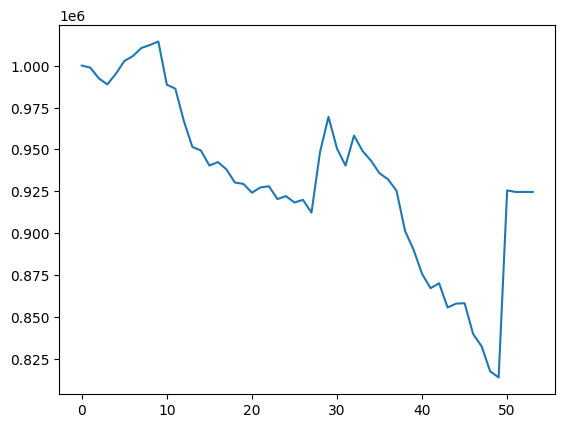

In [74]:
%matplotlib inline
df_account_value.account_value.plot()